In [1]:
!pip install dagster dagit pyngrok pandas seaborn matplotlib scikit-learn


In [17]:
%%writefile pipeline.py

from dagster import op, job, Definitions, fs_io_manager
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from dagster import Output, MetadataValue
from IPython.display import Image, display



@op
def load_wine_data():
    df = pd.read_csv("/content/WineQT.csv")
    return df



from dagster import Output, MetadataValue
from IPython.display import Image, display


@op
def wine_eda_analysis(df):

    if not os.path.exists("eda_plots"):
        os.makedirs("eda_plots")

    path = "eda_plots/wine_heatmap.png"

    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(), cmap="coolwarm")
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

    print("Heatmap saved at:", path)

    return Output(
        path,
        metadata={"heatmap": MetadataValue.path(path)}
    )




@op
def preprocess_wine_data(df):

    # target column
    y = df["quality"]

    # features
    X = df.drop("quality", axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }



def train_model(model, data):
    model.fit(data["X_train"], data["y_train"])
    preds = model.predict(data["X_test"])
    return accuracy_score(data["y_test"], preds)



@op
def train_decision_tree_model(data):
    return train_model(DecisionTreeClassifier(max_depth=20), data)


@op
def train_random_forest_model(data):
    return train_model(RandomForestClassifier(n_estimators=100), data)


@op
def train_gradient_boost_model(data):
    return train_model(GradientBoostingClassifier(), data)


@op
def train_logistic_regression_model(data):
    return train_model(LogisticRegression(max_iter=500), data)



@op
def compare_wine_models(dt_acc, rf_acc, gb_acc, lr_acc):

    report = "\nWine Quality Model Performance (Accuracy)\n"
    report += f"Decision Tree: {dt_acc}\n"
    report += f"Random Forest: {rf_acc}\n"
    report += f"Gradient Boost: {gb_acc}\n"
    report += f"Logistic Regression: {lr_acc}\n"

    best = max(dt_acc, rf_acc, gb_acc, lr_acc)
    report += f"\nBest Accuracy: {best}\n"

    print(report)

    with open("wine_model_report.txt", "w") as f:
        f.write(report)

    return best



@job
def wine_ml_pipeline_job():

    df = load_wine_data()

    wine_eda_analysis(df)

    processed = preprocess_wine_data(df)

    dt = train_decision_tree_model(processed)
    rf = train_random_forest_model(processed)
    gb = train_gradient_boost_model(processed)
    lr = train_logistic_regression_model(processed)

    compare_wine_models(dt, rf, gb, lr)



defs = Definitions(
    jobs=[wine_ml_pipeline_job],
    resources={"io_manager": fs_io_manager}
)


Overwriting pipeline.py


In [7]:
import time

!pkill dagster
!pkill dagster-webserver
print("Stopped old server. Starting new server")
get_ipython().system_raw('dagster dev -f pipeline.py -h 0.0.0.0 -p 3000 &')
time.sleep(10)
print("Server started")

Stopped old server. Starting new server
Server started


In [9]:
from google.colab import output
print("Click the link below to Dagster:")
output.serve_kernel_port_as_window(3000)

Click the link below to Dagster:
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

MODEL COMPARISON RESULTS


EDA VISUALIZATIONS

Displaying: wine_heatmap.png


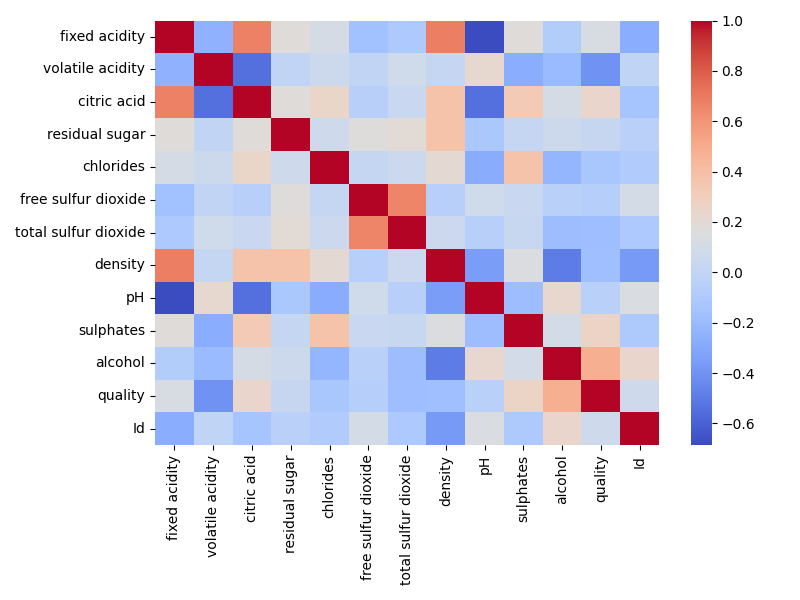

In [16]:
from IPython.display import Image, display
import os

print("MODEL COMPARISON RESULTS\n")
print("\nEDA VISUALIZATIONS\n")

eda_path = "eda_plots"

if os.path.exists(eda_path):

    images = [img for img in os.listdir(eda_path) if img.endswith(".png")]

    if len(images) == 0:
        print("No EDA images found.")
    else:
        for img_file in images:
            print(f"Displaying: {img_file}")
            display(Image(filename=os.path.join(eda_path, img_file)))

else:
    print("EDA folder not found. Please run pipeline first.")
